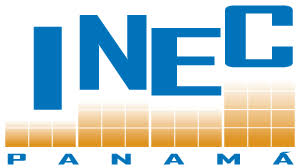

# Kalman

Esta libreria construye la estimacion de Kalman especificada en el punto 2.2 (FIltro de Kalman) del informe. Se busca llevar la información trimestral a frecuencia mensual mediante el uso de un modelo espacio estado.

Esta libreria realiza la estimacion, sin embargo no realiza la interpolacion ni la evaluacion, la cual se realiza con el siguiente modulo.


# Librerías importadas


Se importan las librerías necesarias para realizar el manejo de base de datos y/o proyecciones del modelos.

- pykalman: Librería de filtro de kalman en python.
- pandas: Manejo de bases de datos
- datetime: Manejo de fechas
- numpy: Manejo de matrices
- matploblib.pyplot: Gráficos
- os: Manejo de rutas
- numdifftools: Libreria para calculo de gradientes y derivadas
- statsmodels.tsa.arima_model: Modelos de series de tiempo
- statsmodels.tsa.api: Gráfico de autocorrelaciones
- seaborn: Gráficos adicionales
- ipynb.fs.defs.ConstruccionBasedeDatos: Función definida en el programa ConstruccionBasedeDatos para construir el insumo para hacer la estimación/proyección.

In [1]:
import pykalman as kalman
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os



import numdifftools

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import seaborn as sns

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos

# Rutas para guardar inputs/outputs

In [2]:
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_interpol/'

# Construcción de Base de datos

In [3]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Especificación de variables a estimar 

##### Variables del modelo

In [4]:

#Modelo 1

X =[
'ipc1_viv_Mensual_VariacionAnual',
'ipc1_Mensual_VariacionAnual',
'ipc1_trp_Mensual_VariacionAnual',
'imae_con_nrs_vl_Mensual_VariacionAnual',
'imae_com_exp_vl_Mensual_VariacionAnual',
'imae_man_con_Mensual_VariacionAnual',
'imae_trn_mct_Mensual_VariacionAnual',
'imae_trn_pea_pn_Mensual_VariacionAnual',
'imae_com_imp_vl_Mensual_VariacionAnual',
'imae_man_por_Mensual_VariacionAnual',
'finp_com_Mensual_VariacionAnual',
'finp_sss_otr_Mensual_VariacionAnual',
'fina_am1_dep_Mensual_VariacionAnual',
'finp_osd_nrs_Mensual_VariacionAnual',
'finp_osd_Mensual_VariacionAnual',
'finp_osd_vig_Mensual_VariacionAnual',
'fini_com_Mensual_VariacionAnual'
]

#Modelo 2 - Sin series financieras


X =[
'ipc1_viv_Mensual_VariacionAnual',
'ipc1_Mensual_VariacionAnual',
'ipc1_trp_Mensual_VariacionAnual',
'imae_con_nrs_vl_Mensual_VariacionAnual',
'imae_com_exp_vl_Mensual_VariacionAnual',
'imae_man_con_Mensual_VariacionAnual',
'imae_trn_mct_Mensual_VariacionAnual',
'imae_trn_pea_pn_Mensual_VariacionAnual',
'imae_com_imp_vl_Mensual_VariacionAnual',
'imae_man_por_Mensual_VariacionAnual',
]


#Modelo 3 - Solo series de precios



X =[
'ipc1_viv_Mensual_VariacionAnual',
'ipc1_Mensual_VariacionAnual',
'ipc1_trp_Mensual_VariacionAnual',
]




#Modelo 4 - Solo series de actividad

X =[
'imae_con_nrs_vl_Mensual_VariacionAnual',
'imae_com_exp_vl_Mensual_VariacionAnual',
'imae_man_con_Mensual_VariacionAnual',
'imae_trn_mct_Mensual_VariacionAnual',
'imae_trn_pea_pn_Mensual_VariacionAnual',
'imae_com_imp_vl_Mensual_VariacionAnual',
'imae_man_por_Mensual_VariacionAnual',
]


#Modelo 5 - Variables con correlacion mayor a 0.6

X =[
'ipc1_viv_Mensual_VariacionAnual',
'ipc1_trp_Mensual_VariacionAnual',
'imae_Mensual_VariacionAnual',
'imae_com_imp_vl_Mensual_VariacionAnual',
'imae_com_car_Mensual_VariacionAnual',
]


In [5]:
#Variables a estimar

VariablesPBI = ['pbif_Trimestre_VariacionAnual']

#Seleccion de variables que se usan como X_t

var_sel = {'pbif_Trimestre_VariacionAnual': X
          }

##### Gráfico de variables

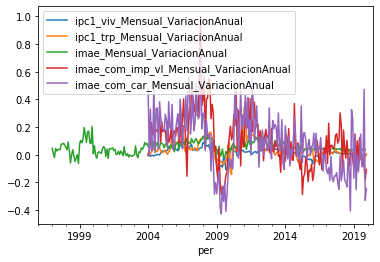

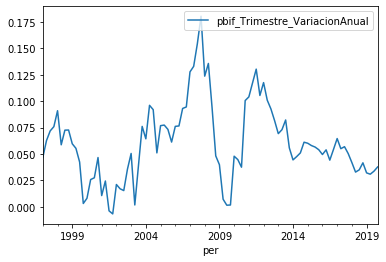

In [6]:
bd_all[var_sel[VariablesPBI[0]]].plot()
bd_all[VariablesPBI].dropna().plot()

#  Filtro de Kalman

Se construye un filtro de Kalman para interpolar el PBI a frecuencia mensual. El PBI trimestral es observado cada tres meses y las contribuciones de cada mes sumadas generan esta variable.

##### Ecuacion de observación/normal/medida:

$$\Delta y_t^T = \Delta y_t^m  + \Delta y_{t-1}^m + \Delta y_{t-2}^m$$
##### Ecuaciones de estado/transicion:
$$\Delta y_{t-1}^m = \phi \Delta y_{t-1}^m + \beta X_t + \epsilon_t$$
$$\epsilon_t = \rho \epsilon_t + \eta_t$$

$X_t$ son las variables usadas para interpolar.

###### __interpol__
La función __interpol__ esta generalizada, construye un filtro de kalman para que interpole:

- __bd_all__: Base de datos que contiene la infomación de variables.
- __X__: Varibles usadas como insumo para interpolar
- __y__: Variable a interpolar
- __frq_1__: Frecuencia de la data __X__
- __frq_2__: Frecuencia de la data __y__
- __params__: Parámetros del filtro
- __test_size__: Tamaño de muestra para realizar el test

###### Otras funciones

La función __t_params__  se usa para estimar parámetros estables del modelo.

In [7]:
def interpol(bd_all, X, y, frq_1, frq_2, params, test_size):
    import numpy as numpy
    from pykalman import KalmanFilter

    bd = bd_all[~(bd_all[X].isna().sum(axis = 1) >0)]
    bd = bd[X].join(bd[y])
    
    #Fijando base de referencia para y en caso se haga un ejercicio de train test
    bd[y[0] + '_data'] = bd[y]
    
    #No se recibe informacion test_size periodos
    if test_size>0:
        bd.loc[-test_size:,y] = 0
    
    bd = bd.fillna(0)

    #Parametros
    phi = params[0]
    rho = params[1]
    var_e = params[2]
    beta = params[3:]
    
    if len(beta) != len(X):
        display('Dimensiones de parametros no consistentes')
    
    frq = int(frq_1/frq_2)
    bd[y] == 0
    
    ##########################################
    #Frecuencia maxima de no observables
    bd['ID_aux'] = 0
    bd.loc[bd[y[0]] != 0,'ID_aux'] = 1
    bd['ID'] = bd['ID_aux'].cumsum()
    bd = bd.drop(['ID_aux'], axis = 1)
    frq_aux = int(bd.groupby(['ID'])[y].count().max())
    bd = bd.drop(['ID'], axis = 1)
    
    frq = min(frq_aux,frq)
    
    ##########################################
    #Creando dos variables de prueba para la interpolacion

    n_ss = frq + 2
    n_qq = bd.shape[0]

    ###############################################
    #Observables

    #Matriz de observables

    H = []
    i = 0
    for date in bd.index:
        i += 1
        if (bd.loc[date,y].values != 0):
            if i>frq:
                i = frq
            aux = [1] * i + [0] * (frq + 2 - i)
            i = 0
        else:
            aux = [0] * (frq + 2)
        H.append([aux])


    observation_offset = [0]
    observation_matrix = np.array(H)
    observation_covariance =  np.zeros([1,1])

    ###############################################
    #Transicion

    #Interceptos
    X_beta = np.matmul(bd[X].values,beta)
    transition_offset = np.zeros([n_qq,n_ss])
    transition_offset[:,0] = X_beta
    transition_offset = transition_offset.tolist()

    #Matriz de transicion
    transition_matrix = np.zeros([n_ss,n_ss])
    transition_matrix[0,0] = phi
    transition_matrix[0,n_ss-1] = 1
    transition_matrix[n_ss-1,n_ss-1] = rho

    for i in range(frq):
        transition_matrix[i+1,i] = 1

    #Varianzas 

    transition_covariance = np.zeros([n_ss, n_ss])
    transition_covariance[n_ss-1,n_ss-1] = var_e

    ###############################################
    #Estados iniciales
    initial_state_mean = np.ones(n_ss) * 0.002
    initial_state_covariance = np.eye(n_ss) * 0.01**2


    # Creando filtro
    kf = KalmanFilter(
        transition_matrix, observation_matrix, 
        transition_covariance, observation_covariance,
        transition_offset,observation_offset,
        initial_state_mean, initial_state_covariance
        #,random_state=random_state
    )
    
    ll = kf.loglikelihood(bd[y])
    
    return ll, kf, bd

def t_params(x):
    #Si no es lista volver lista
    if type(x) != list:
        x = x.tolist()
    
    #Transformacion de beta
    phi = x[0] / (1 + abs(x[0]))
    #Transformacion de rho
    rho = x[1] / (1 + abs(x[1]))
    #Transformacion de sigma
    sigma = x[2] ** 2
    #Betas
    beta = np.abs(x[3:])
    beta = beta.tolist()
    
    params = [phi,rho,sigma] + beta

    return params

# Estimación y Resultados

La estimación del modelo se realiza usando el método de máxima verosimilitud: se busca maximizar la probabilidad de la ocurrencia de las variables, dados los parámetros. Los resultados se guardan en un excel que luego será usado como insumo para la interpolación final del modelo.

Para asegurar que el máximo hallado es uno global se usan distintos puntos iniciales para realizar la estimación.

##### Inspección de variables a ser usadas en el modelo

In [8]:
bd_all[VariablesPBI+ var_sel[VariablesPBI[0]]].dropna(how='all')

,pbif_Trimestre_VariacionAnual,ipc1_viv_Mensual_VariacionAnual,ipc1_trp_Mensual_VariacionAnual,imae_Mensual_VariacionAnual,imae_com_imp_vl_Mensual_VariacionAnual,imae_com_car_Mensual_VariacionAnual
per,,,,,,
1997-01-01,NaN,NaN,NaN,0.047052,NaN,NaN
1997-02-01,NaN,NaN,NaN,0.011035,NaN,NaN
1997-03-01,0.046668,NaN,NaN,-0.019693,NaN,NaN
1997-04-01,NaN,NaN,NaN,0.044577,NaN,NaN
1997-05-01,NaN,NaN,NaN,0.027365,NaN,NaN
...,...,...,...,...,...,...
2019-08-01,NaN,-0.003575,-0.034660,0.031975,-0.050265,-0.083352
2019-09-01,0.033609,-0.003058,-0.044383,0.039755,-0.022842,-0.087550
2019-10-01,NaN,-0.002667,-0.046574,0.033907,-0.077249,0.473145


##### Estimación de máxima verosimilitud del modelo

In [9]:
from numdifftools import Jacobian, Hessian
from scipy.optimize import minimize
np.random.seed(0)
#Cantidad de valores iniciales requeridos para hacer las estimaciones
n_i = 3
#Tamaño del test size
test_size = 0
#Especificando frecuencia de la información
frq1 = 3
frq2 = 1
#Máximo de iteraciones
max_iter = 1000
#Indicador para ver si los resultados reemplazan los anteriores
replace = 1
for varpbi in VariablesPBI:
    X = var_sel[varpbi]
    y = [varpbi]
    
    z_min = lambda params: -interpol(bd_all,X,y,frq1,frq2,t_params(params),test_size)[0]
    z_hess = lambda params: -interpol(bd_all,X,y,frq1,frq2,params,test_size)[0]
    
    LogLikelihood = np.Inf
    
    for i in range(n_i):
    
        x0 = [np.random.normal()*4,np.random.normal()*4,np.random.normal()*0.01] + np.random.normal(size = len(X)).tolist()
        x_opt_ = minimize(z_min, x0, method='Nelder-Mead', options={'disp': False,'maxiter':max_iter})
        x_opt_ = minimize(z_min, x_opt_.x, method='Nelder-Mead', options={'disp': True,'maxiter':max_iter})

        if x_opt_.fun < LogLikelihood:
            x_opt = x_opt_
            LogLikelihood = x_opt.fun
    
    ParametrosOptimizados = t_params(x_opt.x)
    JacobianoParametros = Jacobian(z_hess, step = 0.0000001)(ParametrosOptimizados)
    HessianoParamatros = Hessian(z_hess, step = 0.0000001)(ParametrosOptimizados)
    VarianzaParametros = np.diag(np.linalg.inv(HessianoParamatros))

    ResultadosEstimacion = pd.DataFrame({'Valor': ParametrosOptimizados,'STD': VarianzaParametros**0.5})
    ResultadosEstimacion['T'] = ResultadosEstimacion['Valor'] /ResultadosEstimacion['STD']
    ResultadosEstimacion.index = ['Phi','Rho','Sigma^2'] + X

    if replace == 1:
        
        with pd.ExcelWriter(rutaModelos + 'ModelosKalman.xlsx') as writer:
            ResultadosEstimacion.to_excel(writer, sheet_name=varpbi[0:20])
        replace = 0
    else:
    
        with pd.ExcelWriter(rutaModelos + 'ModelosKalman.xlsx', engine="openpyxl", mode="a") as writer:
            ResultadosEstimacion.to_excel(writer, sheet_name=varpbi[0:20])
    

Optimization terminated successfully.
         Current function value: -1078.366474
         Iterations: 591
         Function evaluations: 896


##### Guardando resultados de los modelos

In [10]:
with pd.ExcelWriter(rutaModelos + 'ModelosKalman.xlsx') as writer:
    ResultadosEstimacion.to_excel(writer, sheet_name=varpbi[0:20])

In [12]:
X

['ipc1_viv_Mensual_VariacionAnual',
 'ipc1_trp_Mensual_VariacionAnual',
 'imae_Mensual_VariacionAnual',
 'imae_com_imp_vl_Mensual_VariacionAnual',
 'imae_com_car_Mensual_VariacionAnual']